# **TREE PARZEN ESTIMATOR(TPE) OPTIMIZATION**

In [14]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from hyperopt import hp, tpe, Trials, fmin
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def objective(params, model_name, X, y):
    if model_name == 'RandomForest':
        n_estimators, max_depth = params
        model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    elif model_name == 'ANN':
        hidden_layer_sizes, alpha = params
        model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        n_neighbors = params[0]
        model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
    elif model_name == 'LogisticRegression':
        C = params[0]
        model = LogisticRegression(C=C, max_iter=1000)
    elif model_name == 'XGBoost':
        n_estimators, max_depth, learning_rate = params
        model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'DecisionTree':
        max_depth = params[0]
        model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
    elif model_name == 'GradientBoosting':
        n_estimators, max_depth, learning_rate = params
        model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators, learning_rate = params
        model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
    elif model_name == 'ExtraTrees':
        n_estimators, max_depth = params
        model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    elif model_name == 'Bagging':
        n_estimators = params[0]
        model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
    elif model_name == 'GaussianNB':
        model = GaussianNB()

    score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    return -score

def tpe_sampler(X_sample, Y_sample, bounds, gamma=0.25):
    n_good = int(np.ceil(gamma * len(Y_sample)))
    sorted_indices = np.argsort(Y_sample.reshape(-1))
    X_good = X_sample[sorted_indices[:n_good]]
    X_bad = X_sample[sorted_indices[n_good:]]

    def propose_new_sample():
        new_sample = []
        for i in range(X_sample.shape[1]):
            good_dist = norm(loc=X_good[:, i].mean(), scale=X_good[:, i].std())
            bad_dist = norm(loc=X_bad[:, i].mean(), scale=X_bad[:, i].std())
            l = bounds[i, 0]
            u = bounds[i, 1]
            samples = np.linspace(l, u, 1000)
            good_pdf = good_dist.pdf(samples)
            bad_pdf = bad_dist.pdf(samples)
            weights = good_pdf / (good_pdf + bad_pdf)
            weights /= weights.sum()
            new_sample.append(np.random.choice(samples, p=weights))
        return new_sample

    return np.array(propose_new_sample())

bounds_dict = {
    'RandomForest': np.array([[10, 200], [1, 20]]),
    'ANN': np.array([[10, 200], [1e-6, 1]]),
    'KNN': np.array([[1, 50]]),
    'LogisticRegression': np.array([[1e-6, 1e+2]]),
    'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
    'DecisionTree': np.array([[1, 20]]),
    'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
    'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
    'ExtraTrees': np.array([[10, 200], [1, 20]]),
    'Bagging': np.array([[10, 200]]),
    'GaussianNB': np.array([])
}


def HPO(model_name, X, y, n_iterations=20):
    bounds = bounds_dict[model_name]
    np.random.seed(42)
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(10, bounds.shape[0]))
    Y_sample = np.array([objective(params, model_name, X, y) for params in X_sample]).reshape(-1, 1)

    for i in range(n_iterations):
        new_sample = tpe_sampler(X_sample, Y_sample, bounds)
        new_value = objective(new_sample, model_name, X, y)
        X_sample = np.vstack((X_sample, new_sample))
        Y_sample = np.vstack((Y_sample, np.array(new_value).reshape(-1, 1)))

    best_index = np.argmin(Y_sample)
    best_params = X_sample[best_index]
    optimized_accuracy = -np.min(Y_sample)

    default_model = None
    if model_name == 'RandomForest':
        default_model = RandomForestClassifier(random_state=42)
    elif model_name == 'ANN':
        default_model = MLPClassifier(max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        default_model = KNeighborsClassifier()
    elif model_name == 'LogisticRegression':
        default_model = LogisticRegression(max_iter=1000)
    elif model_name == 'XGBoost':
        default_model = XGBClassifier(random_state=42)
    elif model_name == 'DecisionTree':
        default_model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'GradientBoosting':
        default_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'AdaBoost':
        default_model = AdaBoostClassifier(random_state=42)
    elif model_name == 'ExtraTrees':
        default_model = ExtraTreesClassifier(random_state=42)
    elif model_name == 'Bagging':
        default_model = BaggingClassifier(random_state=42)
    elif model_name == 'GaussianNB':
        default_model = GaussianNB()

    default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

    return {
        'optimized_params': best_params,
        'optimized_accuracy': optimized_accuracy,
        'default_accuracy': default_accuracy
    }

def optimize_model(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    results = HPO(model_name, X_preprocessed, y)

    optimized_model = None
    if model_name == 'RandomForest':
        optimized_model = RandomForestClassifier(n_estimators=int(results['optimized_params'][0]), max_depth=int(results['optimized_params'][1]), random_state=42)
    elif model_name == 'ANN':
        optimized_model = MLPClassifier(hidden_layer_sizes=(int(results['optimized_params'][0]),), alpha=results['optimized_params'][1], max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        optimized_model = KNeighborsClassifier(n_neighbors=int(results['optimized_params'][0]))
    elif model_name == 'LogisticRegression':
        optimized_model = LogisticRegression(C=results['optimized_params'][0], max_iter=1000)
    elif model_name == 'XGBoost':
        optimized_model = XGBClassifier(n_estimators=int(results['optimized_params'][0]), max_depth=int(results['optimized_params'][1]), learning_rate=results['optimized_params'][2], random_state=42)
    elif model_name == 'DecisionTree':
        optimized_model = DecisionTreeClassifier(max_depth=int(results['optimized_params'][0]), random_state=42)
    elif model_name == 'GradientBoosting':
        optimized_model = GradientBoostingClassifier(n_estimators=int(results['optimized_params'][0]), max_depth=int(results['optimized_params'][1]), learning_rate=results['optimized_params'][2], random_state=42)
    elif model_name == 'AdaBoost':
        optimized_model = AdaBoostClassifier(n_estimators=int(results['optimized_params'][0]), learning_rate=results['optimized_params'][1], random_state=42)
    elif model_name == 'ExtraTrees':
        optimized_model = ExtraTreesClassifier(n_estimators=int(results['optimized_params'][0]), max_depth=int(results['optimized_params'][1]), random_state=42)
    elif model_name == 'Bagging':
        optimized_model = BaggingClassifier(n_estimators=int(results['optimized_params'][0]), random_state=42)
    elif model_name == 'GaussianNB':
        optimized_model = GaussianNB()

    if optimized_model is not None:
        roc_auc_optimized = cross_val_score(optimized_model, X_preprocessed, y, cv=5, scoring='roc_auc').mean()
        accuracy_optimized = cross_val_score(optimized_model, X_preprocessed, y, cv=5, scoring='accuracy').mean()
        print(f"Optimization Results for {model_name} on dataset {dataset}:")
        print(f"  Optimized Parameters: {results['optimized_params']}")
        print(f"  Optimized Accuracy: {accuracy_optimized}")
        print(f"  Optimized ROC AUC: {roc_auc_optimized}")
   

    default_model = None
    if model_name == 'RandomForest':
        default_model = RandomForestClassifier(random_state=42)
    elif model_name == 'ANN':
        default_model = MLPClassifier(max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        default_model = KNeighborsClassifier()
    elif model_name == 'LogisticRegression':
        default_model = LogisticRegression(max_iter=1000)
    elif model_name == 'XGBoost':
        default_model = XGBClassifier(random_state=42)
    elif model_name == 'DecisionTree':
        default_model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'GradientBoosting':
        default_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'AdaBoost':
        default_model = AdaBoostClassifier(random_state=42)
    elif model_name == 'ExtraTrees':
        default_model = ExtraTreesClassifier(random_state=42)
    elif model_name == 'Bagging':
        default_model = BaggingClassifier(random_state=42)
    elif model_name == 'GaussianNB':
        default_model = GaussianNB()

    if default_model is not None:
        roc_auc_default = cross_val_score(default_model, X_preprocessed, y, cv=5, scoring='roc_auc').mean()
        accuracy_default = cross_val_score(default_model, X_preprocessed, y, cv=5, scoring='accuracy').mean()
        print(f"  Default Accuracy: {accuracy_default}")
        print(f"  Default ROC AUC: {roc_auc_default}")




FINDING ACCURACY USING HYPEROPT FOR COMAPRISON

In [15]:
def HPO_hyperopt(model_name, X, y):
    space = {
        
    'RandomForest': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'ANN': {
        'hidden_layer_sizes': hp.quniform('hidden_layer_sizes', 10, 200, 1),
        'alpha': hp.uniform('alpha', 1e-6, 1)
    },
    'KNN': {
        'n_neighbors': hp.quniform('n_neighbors', 1, 50, 1)
    },
    'LogisticRegression': {
        'C': hp.loguniform('C', np.log(1e-6), np.log(1e+2))
    },
    'XGBoost': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'DecisionTree': {
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'GradientBoosting': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'AdaBoost': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'ExtraTrees': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'Bagging': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1)
    }
}
        
    
    def objective_hyperopt(params):
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'ANN':
            model = MLPClassifier(hidden_layer_sizes=(int(params['hidden_layer_sizes']),), alpha=params['alpha'], max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=int(params['n_neighbors']))
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(C=params['C'], max_iter=1000)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(n_estimators=int(params['n_estimators']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'ExtraTrees':
            model = ExtraTreesClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'Bagging':
            model = BaggingClassifier(n_estimators=int(params['n_estimators']), random_state=42)
        
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    trials = Trials()
    best_params = fmin(objective_hyperopt, space[model_name], algo=tpe.suggest, max_evals=20, trials=trials)

    best_params_values = {key: best_params[key] for key in space[model_name]}
    
    best_model = None
    if model_name == 'RandomForest':
        best_model = RandomForestClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'ANN':
        best_model = MLPClassifier(hidden_layer_sizes=(int(best_params_values['hidden_layer_sizes']),), alpha=best_params_values['alpha'], max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        best_model = KNeighborsClassifier(n_neighbors=int(best_params_values['n_neighbors']))
    elif model_name == 'LogisticRegression':
        best_model = LogisticRegression(C=best_params_values['C'], max_iter=1000)
    elif model_name == 'XGBoost':
        best_model = XGBClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'DecisionTree':
        best_model = DecisionTreeClassifier(max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'GradientBoosting':
        best_model = GradientBoostingClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'AdaBoost':
        best_model = AdaBoostClassifier(n_estimators=int(best_params_values['n_estimators']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'ExtraTrees':
        best_model = ExtraTreesClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'Bagging':
        best_model = BaggingClassifier(n_estimators=int(best_params_values['n_estimators']), random_state=42)

    best_model.fit(X, y)
    
    return best_params_values, best_model

def optimize_model_hyperopt(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    best_params_hyperopt, best_model_hyperopt = HPO_hyperopt(model_name, X_preprocessed, y)

    cross_val_scores_hyperopt = cross_val_score(best_model_hyperopt, X_preprocessed, y, cv=5, scoring='accuracy').mean()

    y_pred_hyperopt = cross_val_predict(best_model_hyperopt, X_preprocessed, y, cv=5, method='predict_proba')[:, 1]
    roc_auc_hyperopt = roc_auc_score(y, y_pred_hyperopt)

    print(f"Optimization Results for {model_name} using Hyperopt on dataset {dataset}:")
    print(f"  Optimized Parameters-Hyperopt: {best_params_hyperopt}")
    print(f"  Accuracy - Hyperopt: {cross_val_scores_hyperopt}")
    print(f"  ROC-AUC Score - Hyperopt: {roc_auc_hyperopt}")




KNN

In [16]:

optimize_model('KNN', 'mushrooms.csv', 'class')
optimize_model_hyperopt('KNN', 'mushrooms.csv', 'class')



Optimization Results for KNN on dataset mushrooms.csv:
  Optimized Parameters: [2.76576577]
  Optimized Accuracy: 0.9545764304660856
  Optimized ROC AUC: 0.9569285532286635
  Default Accuracy: 0.9278522925350512
  Default ROC AUC: 0.9671154966148171
100%|██████████| 20/20 [01:19<00:00,  3.97s/trial, best loss: -0.9301922697991664]
Optimization Results for KNN using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_neighbors': 6.0}
  Accuracy - Hyperopt: 0.9301922697991664
  ROC-AUC Score - Hyperopt: 0.9635519628937731


ANN

In [17]:

optimize_model('ANN', 'mushrooms.csv', 'class')
optimize_model_hyperopt('ANN', 'mushrooms.csv', 'class')



Optimization Results for ANN on dataset mushrooms.csv:
  Optimized Parameters: [66.2962963  0.072073 ]
  Optimized Accuracy: 0.9298140204622964
  Optimized ROC AUC: 0.9982970472574978
  Default Accuracy: 0.9112213717317166
  Default ROC AUC: 0.9981283374439247
100%|██████████| 20/20 [02:27<00:00,  7.37s/trial, best loss: -0.9278421371731718]
Optimization Results for ANN using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'hidden_layer_sizes': 178.0, 'alpha': 0.10722366259718999}
  Accuracy - Hyperopt: 0.9278421371731718
  ROC-AUC Score - Hyperopt: 0.9892112936301106


LOGISTIC REGRESSION

In [18]:

optimize_model('LogisticRegression', 'mushrooms.csv', 'class')
optimize_model_hyperopt('LogisticRegression', 'mushrooms.csv', 'class')


Optimization Results for LogisticRegression on dataset mushrooms.csv:
  Optimized Parameters: [95.07143069]
  Optimized Accuracy: 0.9423687760515348
  Optimized ROC AUC: 0.9979395689920928
  Default Accuracy: 0.9193427813565744
  Default ROC AUC: 0.9977293960850657
100%|██████████| 20/20 [00:02<00:00,  8.79trial/s, best loss: -0.9310399393709738]
Optimization Results for LogisticRegression using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'C': 3.200000980875416}
  Accuracy - Hyperopt: 0.9310399393709738
  ROC-AUC Score - Hyperopt: 0.9894313375563641


RANDOM FOREST

In [19]:

optimize_model('RandomForest', 'mushrooms.csv', 'class')
optimize_model_hyperopt('RandomForest', 'mushrooms.csv', 'class')



Optimization Results for RandomForest on dataset mushrooms.csv:
  Optimized Parameters: [100.34034034   8.36036036]
  Optimized Accuracy: 0.9412761652140963
  Optimized ROC AUC: 0.9999504937714786
  Default Accuracy: 0.9315465706707086
  Default ROC AUC: 0.9997386496340942
100%|██████████| 20/20 [00:31<00:00,  1.57s/trial, best loss: -0.9397977264115195]
Optimization Results for RandomForest using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 81.0, 'max_depth': 10.0}
  Accuracy - Hyperopt: 0.9397977264115195
  ROC-AUC Score - Hyperopt: 0.9882654567204061


XGBOOST

In [20]:
optimize_model('XGBoost', 'mushrooms.csv', 'class')
optimize_model_hyperopt('XGBoost', 'mushrooms.csv', 'class')



Optimization Results for XGBoost on dataset mushrooms.csv:
  Optimized Parameters: [139.70970971   2.36936937   0.42838839]
  Optimized Accuracy: 0.9913793103448276
  Optimized ROC AUC: 0.9998311321284794
  Default Accuracy: 0.9602221295945433
  Default ROC AUC: 0.9973661471549864
100%|██████████| 20/20 [00:30<00:00,  1.53s/trial, best loss: -0.9782024251610458]
Optimization Results for XGBoost using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 178.0, 'max_depth': 3.0, 'learning_rate': 0.22952823846472012}
  Accuracy - Hyperopt: 0.9782024251610458
  ROC-AUC Score - Hyperopt: 0.9998343298624731


DECISION TREE

In [21]:
optimize_model('DecisionTree', 'mushrooms.csv', 'class')
optimize_model_hyperopt('DecisionTree', 'mushrooms.csv', 'class')



Optimization Results for DecisionTree on dataset mushrooms.csv:
  Optimized Parameters: [8.11626226]
  Optimized Accuracy: 0.996182796513831
  Optimized ROC AUC: 0.9962522570132558
  Default Accuracy: 0.996182796513831
  Default ROC AUC: 0.9962522570132558
100%|██████████| 20/20 [00:01<00:00, 15.51trial/s, best loss: -0.996182796513831]
Optimization Results for DecisionTree using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'max_depth': 19.0}
  Accuracy - Hyperopt: 0.996182796513831
  ROC-AUC Score - Hyperopt: 0.9962545198211878


ADA BOOST

In [22]:
optimize_model('AdaBoost', 'mushrooms.csv', 'class')
optimize_model_hyperopt('AdaBoost', 'mushrooms.csv', 'class')


Optimization Results for AdaBoost on dataset mushrooms.csv:
  Optimized Parameters: [44.54674377  0.09986821]
  Optimized Accuracy: 0.962447063281546
  Optimized ROC AUC: 0.9933331551688409
  Default Accuracy: 0.9288359226979918
  Default ROC AUC: 0.9993785905303392
100%|██████████| 20/20 [00:56<00:00,  2.83s/trial, best loss: -0.9612180371352785]
Optimization Results for AdaBoost using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 144.0, 'learning_rate': 0.07808349497492711}
  Accuracy - Hyperopt: 0.9612180371352785
  ROC-AUC Score - Hyperopt: 0.9943926423525208


EXTRA TREES

In [23]:
optimize_model('ExtraTrees', 'mushrooms.csv', 'class')
optimize_model_hyperopt('ExtraTrees', 'mushrooms.csv', 'class')



Optimization Results for ExtraTrees on dataset mushrooms.csv:
  Optimized Parameters: [134.76476476   7.5995996 ]
  Optimized Accuracy: 0.944970594922319
  Optimized ROC AUC: 0.9998803346378071
  Default Accuracy: 0.931792800303145
  Default ROC AUC: 0.9996042538910224
100%|██████████| 20/20 [00:24<00:00,  1.20s/trial, best loss: -0.9353642288745737]
Optimization Results for ExtraTrees using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 152.0, 'max_depth': 14.0}
  Accuracy - Hyperopt: 0.9353642288745737
  ROC-AUC Score - Hyperopt: 0.9900369741763342


BAGGING

In [24]:
optimize_model('Bagging', 'mushrooms.csv', 'class')
optimize_model_hyperopt('Bagging', 'mushrooms.csv', 'class')



Optimization Results for Bagging on dataset mushrooms.csv:
  Optimized Parameters: [27.11711712]
  Optimized Accuracy: 0.9433502084122773
  Optimized ROC AUC: 0.9991009911875877
  Default Accuracy: 0.9407640773020084
  Default ROC AUC: 0.9967909030027198
100%|██████████| 20/20 [01:55<00:00,  5.77s/trial, best loss: -0.9438428192497158]
Optimization Results for Bagging using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 26.0}
  Accuracy - Hyperopt: 0.9438428192497158
  ROC-AUC Score - Hyperopt: 0.9990073749305763


PLOTTING LEARNING RATE DISTRIBUTION CURVES

In [25]:
def PLOT(model_name, dataset, target):
    import numpy as np
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    import matplotlib.pyplot as plt

    def objective(params, model_name, X, y):
        if model_name == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'ANN':
            hidden_layer_sizes, alpha = params
            model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            n_neighbors = params[0]
            model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
        elif model_name == 'LogisticRegression':
            C = params[0]
            model = LogisticRegression(C=C, max_iter=1000)
        elif model_name == 'XGBoost':
            n_estimators, max_depth, learning_rate = params
            model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'DecisionTree':
            max_depth = params[0]
            model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
        elif model_name == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
        elif model_name == 'ExtraTrees':
            n_estimators, max_depth = params
            model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'Bagging':
            n_estimators = params[0]
            model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
        elif model_name == 'GaussianNB':
            model = GaussianNB()

        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    def sample_params(bounds, size=1):
        return np.random.uniform(bounds[:, 0], bounds[:, 1], size=(size, bounds.shape[0]))

    def tpe_sample(good, bad, bounds):
        samples = sample_params(bounds, size=1000)
        good_kde = np.zeros(samples.shape[0])
        bad_kde = np.zeros(samples.shape[0])

        for i, sample in enumerate(samples):
            good_kde[i] = np.mean(np.exp(-np.sum((good - sample) ** 2, axis=1)))
            bad_kde[i] = np.mean(np.exp(-np.sum((bad - sample) ** 2, axis=1)))

        weights = good_kde / (good_kde + bad_kde)
        index = np.argmax(weights)
        return samples[index]

    def HPO_TPE(model_name, X, y):
        bounds = bounds_dict[model_name]
        np.random.seed(42)
        X_sample = sample_params(bounds, size=10)
        Y_sample = np.array([objective(params, model_name, X, y) for params in X_sample]).reshape(-1, 1)

        n_iterations = 20
        learning_rates = []
        accuracies = []

        for i in range(n_iterations):
            median = np.median(Y_sample)
            good = X_sample[Y_sample.flatten() <= median]
            bad = X_sample[Y_sample.flatten() > median]

            next_sample = tpe_sample(good, bad, bounds)
            next_value = objective(next_sample, model_name, X, y)

            learning_rate = None
            if model_name in ['XGBoost', 'GradientBoosting']:
                learning_rate = next_sample[-1]
                learning_rates.append(learning_rate)

                if model_name == 'XGBoost':
                    model = XGBClassifier(n_estimators=int(next_sample[0]), max_depth=int(next_sample[1]),
                                          learning_rate=learning_rate, random_state=42)
                elif model_name == 'GradientBoosting':
                    model = GradientBoostingClassifier(n_estimators=int(next_sample[0]), max_depth=int(next_sample[1]),
                                                       learning_rate=learning_rate, random_state=42)
                accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
                accuracies.append(accuracy)

            X_sample = np.vstack((X_sample, next_sample))
            Y_sample = np.vstack((Y_sample, np.array(next_value).reshape(-1, 1)))

        best_index = np.argmin(Y_sample)
        best_params = X_sample[best_index]
        optimized_accuracy = -np.min(Y_sample)
        
        default_model = None
        if model_name == 'RandomForest':
            default_model = RandomForestClassifier(random_state=42)
        elif model_name == 'ANN':
            default_model = MLPClassifier(max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            default_model = KNeighborsClassifier()
        elif model_name == 'LogisticRegression':
            default_model = LogisticRegression(max_iter=1000)
        elif model_name == 'XGBoost':
            default_model = XGBClassifier(random_state=42)
        elif model_name == 'DecisionTree':
            default_model = DecisionTreeClassifier(random_state=42)
        elif model_name == 'GradientBoosting':
            default_model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'AdaBoost':
            default_model = AdaBoostClassifier(random_state=42)
        elif model_name == 'ExtraTrees':
            default_model = ExtraTreesClassifier(random_state=42)
        elif model_name == 'Bagging':
            default_model = BaggingClassifier(random_state=42)
        elif model_name == 'GaussianNB':
            default_model = GaussianNB()
        
        default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

        return {
            'optimized_params': best_params,
            'optimized_accuracy': optimized_accuracy,
            'default_accuracy': default_accuracy,
            'learning_rates': learning_rates,
            'accuracies': accuracies
        }
    
    def plot_learning_rate_accuracy(learning_rates, accuracies):
        iterations = range(1, len(learning_rates) + 1)
        plt.plot(iterations, learning_rates, marker='o', label='Learning Rate')
        plt.plot(iterations, accuracies, marker='x', label='Accuracy')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Learning Rate and Accuracy vs Iteration')
        plt.legend()
        plt.grid(True)
        plt.show()

    def optimize_model(model_name, dataset, target_column):
        data = pd.read_csv(dataset)
        X = data.drop(columns=[target_column])
        y = data[target_column]

        le = LabelEncoder()
        y = le.fit_transform(y)

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X.select_dtypes(include=['number']).columns

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        X_preprocessed = preprocessor.fit_transform(X)

        results = HPO_TPE(model_name, X_preprocessed, y)
        plot_learning_rate_accuracy(results['learning_rates'], results['accuracies'])

    bounds_dict = {
        'RandomForest': np.array([[10, 200], [1, 20]]),
        'ANN': np.array([[10, 200], [1e-6, 1]]),
        'KNN': np.array([[1, 50]]),
        'LogisticRegression': np.array([[1e-6, 1e+2]]),
        'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'DecisionTree': np.array([[1, 20]]),
        'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
        'ExtraTrees': np.array([[10, 200], [1, 20]]),
        'Bagging': np.array([[10, 200]]),
    }

    optimize_model(model_name, dataset, target)


LEARNING RATE DISTRIBUTION CURVE -> XGBOOST

/var/folders/9_/bsv9dk5n4w99dp08k7psysnw0000gn/T/ipykernel_3511/496803252.py:69: RuntimeWarning: invalid value encountered in divide
  weights = good_kde / (good_kde + bad_kde)


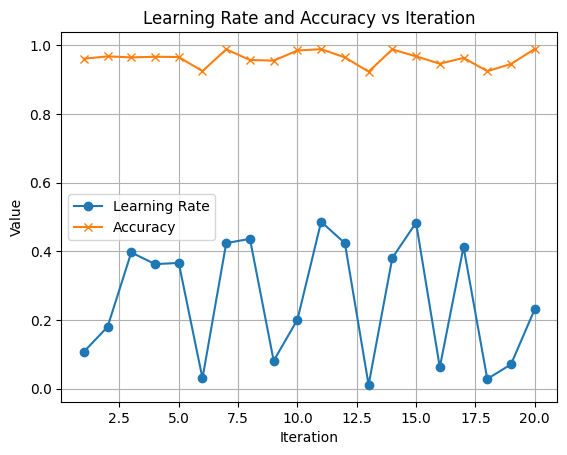

In [26]:
PLOT('XGBoost','mushrooms.csv','class')

LEARNING RATE DISTRIBUTION CURVE -> GRADIENT BOOSTING

/var/folders/9_/bsv9dk5n4w99dp08k7psysnw0000gn/T/ipykernel_3511/496803252.py:69: RuntimeWarning: invalid value encountered in divide
  weights = good_kde / (good_kde + bad_kde)


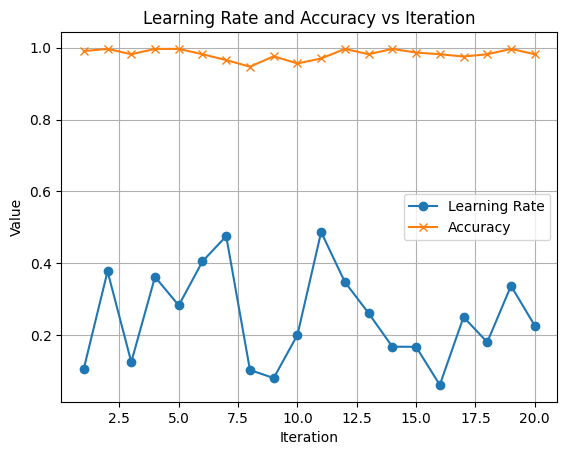

In [27]:
PLOT('GradientBoosting','mushrooms.csv','class')

## Learning Rate Curve for GradientBoosting TPE vs HyperOpt

<img src="gradientTPE.png" alt="TPE Optimization" style="width: 45%; float: left; margin-right: 5%;">
<img src="gradientHyperOpt.png" alt="HyperOpt Optimization" style="width: 45%; float: left;">



## Learning Rate Curve for XGBoost TPE vs HyperOpt

<img src="xgTPE.png" alt="TPE Optimization" style="width: 45%; float: left; margin-right: 5%;">
<img src="xgHyperOpt.png" alt="HyperOpt Optimization" style="width: 45%; float: left;">


PLOTTING HISTOGRAM OF LEARNING RATE VS DENSITY FOR TPE

In [1]:
def PLOT_HIST(model_name, dataset, target):
    import numpy as np
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    import matplotlib.pyplot as plt

    def objective(params, model_name, X, y):
        if model_name == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'ANN':
            hidden_layer_sizes, alpha = params
            model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            n_neighbors = params[0]
            model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
        elif model_name == 'LogisticRegression':
            C = params[0]
            model = LogisticRegression(C=C, max_iter=1000)
        elif model_name == 'XGBoost':
            n_estimators, max_depth, learning_rate = params
            model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'DecisionTree':
            max_depth = params[0]
            model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
        elif model_name == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
        elif model_name == 'ExtraTrees':
            n_estimators, max_depth = params
            model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'Bagging':
            n_estimators = params[0]
            model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
        elif model_name == 'GaussianNB':
            model = GaussianNB()

        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    def sample_params(bounds, size=1):
        return np.random.uniform(bounds[:, 0], bounds[:, 1], size=(size, bounds.shape[0]))

    def tpe_sample(good, bad, bounds):
        samples = sample_params(bounds, size=1000)
        good_kde = np.zeros(samples.shape[0])
        bad_kde = np.zeros(samples.shape[0])

        for i, sample in enumerate(samples):
            good_kde[i] = np.mean(np.exp(-np.sum((good - sample) ** 2, axis=1)))
            bad_kde[i] = np.mean(np.exp(-np.sum((bad - sample) ** 2, axis=1)))

        weights = good_kde / (good_kde + bad_kde)
        index = np.argmax(weights)
        return samples[index]

    def HPO_TPE(model_name, X, y):
        bounds = bounds_dict[model_name]
        np.random.seed(42)
        X_sample = sample_params(bounds, size=10)
        Y_sample = np.array([objective(params, model_name, X, y) for params in X_sample]).reshape(-1, 1)

        n_iterations = 20
        learning_rates = []
        accuracies = []

        for i in range(n_iterations):
            median = np.median(Y_sample)
            good = X_sample[Y_sample.flatten() <= median]
            bad = X_sample[Y_sample.flatten() > median]

            next_sample = tpe_sample(good, bad, bounds)
            next_value = objective(next_sample, model_name, X, y)

            learning_rate = None
            if model_name in ['XGBoost', 'GradientBoosting']:
                learning_rate = next_sample[-1]
                learning_rates.append(learning_rate)

                if model_name == 'XGBoost':
                    model = XGBClassifier(n_estimators=int(next_sample[0]), max_depth=int(next_sample[1]),
                                          learning_rate=learning_rate, random_state=42)
                elif model_name == 'GradientBoosting':
                    model = GradientBoostingClassifier(n_estimators=int(next_sample[0]), max_depth=int(next_sample[1]),
                                                       learning_rate=learning_rate, random_state=42)
                accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
                accuracies.append(accuracy)

            X_sample = np.vstack((X_sample, next_sample))
            Y_sample = np.vstack((Y_sample, np.array(next_value).reshape(-1, 1)))

        best_index = np.argmin(Y_sample)
        best_params = X_sample[best_index]
        optimized_accuracy = -np.min(Y_sample)
        
        default_model = None
        if model_name == 'RandomForest':
            default_model = RandomForestClassifier(random_state=42)
        elif model_name == 'ANN':
            default_model = MLPClassifier(max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            default_model = KNeighborsClassifier()
        elif model_name == 'LogisticRegression':
            default_model = LogisticRegression(max_iter=1000)
        elif model_name == 'XGBoost':
            default_model = XGBClassifier(random_state=42)
        elif model_name == 'DecisionTree':
            default_model = DecisionTreeClassifier(random_state=42)
        elif model_name == 'GradientBoosting':
            default_model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'AdaBoost':
            default_model = AdaBoostClassifier(random_state=42)
        elif model_name == 'ExtraTrees':
            default_model = ExtraTreesClassifier(random_state=42)
        elif model_name == 'Bagging':
            default_model = BaggingClassifier(random_state=42)
        elif model_name == 'GaussianNB':
            default_model = GaussianNB()
        
        default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

        return {
            'optimized_params': best_params,
            'optimized_accuracy': optimized_accuracy,
            'default_accuracy': default_accuracy,
            'learning_rates': learning_rates,
            'accuracies': accuracies
        }
    
    def plot_learning_rate_histogram(learning_rates):
        plt.hist(learning_rates, bins=10, edgecolor='k', alpha=0.7)
        plt.xlabel('Learning Rate')
        plt.ylabel('Density')
        plt.title('Histogram of Learning Rates')
        plt.grid(True)
        plt.show()

    def optimize_model(model_name, dataset, target_column):
        data = pd.read_csv(dataset)
        X = data.drop(columns=[target_column])
        y = data[target_column]

        le = LabelEncoder()
        y = le.fit_transform(y)

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X.select_dtypes(include=['number']).columns

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        X_preprocessed = preprocessor.fit_transform(X)

        results = HPO_TPE(model_name, X_preprocessed, y)
        plot_learning_rate_histogram(results['learning_rates'])

    bounds_dict = {
        'RandomForest': np.array([[10, 200], [1, 20]]),
        'ANN': np.array([[10, 200], [1e-6, 1]]),
        'KNN': np.array([[1, 50]]),
        'LogisticRegression': np.array([[1e-6, 1e+2]]),
        'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'DecisionTree': np.array([[1, 20]]),
        'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
        'ExtraTrees': np.array([[10, 200], [1, 20]]),        
        'Bagging': np.array([[10, 200]]),
    }

    optimize_model(model_name, dataset, target)




/var/folders/9_/bsv9dk5n4w99dp08k7psysnw0000gn/T/ipykernel_1367/1747066032.py:69: RuntimeWarning: invalid value encountered in divide
  weights = good_kde / (good_kde + bad_kde)


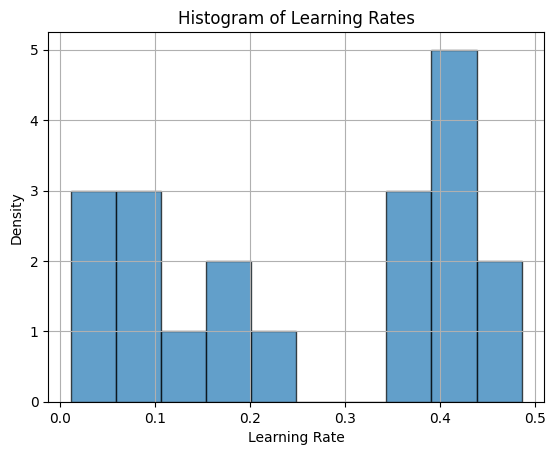

In [2]:
PLOT_HIST('XGBoost','mushrooms.csv','class')

/var/folders/9_/bsv9dk5n4w99dp08k7psysnw0000gn/T/ipykernel_1367/1747066032.py:69: RuntimeWarning: invalid value encountered in divide
  weights = good_kde / (good_kde + bad_kde)


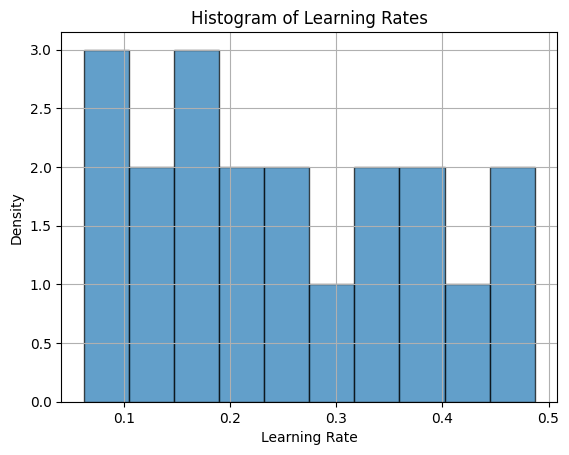

In [3]:
PLOT_HIST('GradientBoosting','mushrooms.csv','class')